In [75]:
# 필수 라이브러리
import pandas as pd
import re
# SAST&LLM 출력본 가져오기
each_functions = pd.read_csv('function_count_summary.csv')
results_llama = pd.read_json('results_llama3-8b.jsonl', lines=True)
results_semgrep = pd.read_json('results_semgrep.jsonl', lines=True)
results_mistral = pd.read_json('results_mistral.jsonl', lines=True)
results_gpt4 = pd.read_json('results_gpt4.jsonl', lines=True)
results_gpt3 = pd.read_json('results_gpt3.5.jsonl', lines=True)

# 정규표현식으로 vulnerability_count 숫자만 추출
# 취약점 개수만 필터링 (없으면 0)
def extract_vuln_count(text):
    match = re.search(r'"vulnerability_count"\s*:\s*(\d+)', text)
    return int(match.group(1)) if match else 0
# 취약점 발생 라인 필터링(다중 리스트)
def extract_vuln_lines(text):
    lines = re.findall(r'"line"\s*:\s*(\d+)', text)
    return [int(line) for line in lines]
# Semgrep 결과는 정직한(?) json이라 따로 함수 구현
def extract_vuln_lines_semgrep(text):
    return [vuln['line'] for vuln in text['vulnerabilities']]
def extract_vuln_count_semgrep(text):
    return text['vulnerability_count']

# 각 모델 결과 파일별 필터링
# Semgrep
results_semgrep['semgrep_vulner_count'] = results_semgrep['output'].apply(extract_vuln_count_semgrep)
results_semgrep['semgrep_vulner_line'] = results_semgrep['output'].apply(extract_vuln_lines_semgrep)
# Meta-Llama-3-8B
results_llama['llama_vulner_count'] = results_llama['output'].apply(extract_vuln_count)
results_llama['llama_vulner_line'] = results_llama['output'].apply(extract_vuln_lines)
# Mistral-7B
results_mistral['mistral_vulner_count'] = results_mistral['output'].apply(extract_vuln_count)
results_mistral['mistral_vulner_line'] = results_mistral['output'].apply(extract_vuln_lines)
# GPT4
results_gpt4['gpt4_vulner_count'] = results_gpt4['output'].apply(extract_vuln_count)
results_gpt4['gpt4_vulner_line'] = results_gpt4['output'].apply(extract_vuln_lines)
# GPT4
results_gpt3['gpt3.5_vulner_count'] = results_gpt3['output'].apply(extract_vuln_count_semgrep)
results_gpt3['gpt3.5_vulner_line'] = results_gpt3['output'].apply(extract_vuln_lines_semgrep)

# Meta-Llama-3-8B와 Semgrep
results_llama = results_llama[['CVE', 'llama_vulner_count', 'llama_vulner_line']]
results_semgrep = results_semgrep[['CVE', 'semgrep_vulner_count', 'semgrep_vulner_line']]
# Merge 진행
merged_data = pd.merge(left=results_semgrep,
                       right=results_llama,
                       on='CVE')
merged_data = pd.merge(left=merged_data,
                       right=results_mistral,
                       on='CVE')
merged_data = merged_data.drop(columns=['output'])
merged_data = pd.merge(left=merged_data,
                       right=results_gpt4,
                       on='CVE')
merged_data = merged_data.drop(columns='output')
merged_data = pd.merge(left=merged_data,
                       right=each_functions,
                       left_on='CVE',
                       right_on='filename')
merged_data = pd.merge(left=merged_data,
                       right=results_gpt3,
                       on='CVE')
# 필요한 부분만 Redefinition
merged_data = merged_data[['CVE', 'functions', 'semgrep_vulner_count',
                           'semgrep_vulner_line', 'llama_vulner_count', 'llama_vulner_line',
                           'mistral_vulner_count', 'mistral_vulner_line', 'gpt4_vulner_count', 'gpt4_vulner_line',
                           'gpt3.5_vulner_count', 'gpt3.5_vulner_line']]
merged_data.head()

,CVE,functions,semgrep_vulner_count,semgrep_vulner_line,llama_vulner_count,llama_vulner_line,mistral_vulner_count,mistral_vulner_line,gpt4_vulner_count,gpt4_vulner_line,gpt3.5_vulner_count,gpt3.5_vulner_line
0,CVE-2022-1719,40,1,[532],0,[],1,[67],3,"[1010, 1080, 920]",0,[]
1,CVE-2022-21122,4,0,[],2,"[14, 6]",2,"[4, 6]",1,[23],1,[29]
2,CVE-2022-21671,4,0,[],3,"[5, 14, 34]",3,"[9, 16, 24]",1,[47],1,[23]
3,CVE-2022-22116,1,3,"[139, 139, 139]",2,"[123, 456]",3,[6],2,"[108, 114]",1,[53]
4,CVE-2022-22126,2,0,[],1,[],1,[20],0,[],1,[15]


In [89]:
# 전체 함수 수 (각 CVE별 함수값 sum -> Marked Function을 구하기 위함)
total_functions = merged_data['functions'].sum()

# Marked Function Ratio
mfr_semgrep = merged_data['semgrep_vulner_count'].sum() / total_functions
mfr_llama = merged_data['llama_vulner_count'].sum() / total_functions
mfr_mistral = merged_data['mistral_vulner_count'].sum() / total_functions
mfr_gpt4 = merged_data['gpt4_vulner_count'].sum() / total_functions
mfr_gpt3 = merged_data['gpt3.5_vulner_count'].sum() / total_functions

# Vulnerability Detection Ratio 시나리오 1(선행연구) 기준 : 각 CVE에서 하나라도 탐지되면 탐지 성공
vdr_s1_semgrep = (merged_data['semgrep_vulner_count'] > 0).sum() / len(merged_data)
vdr_s1_llama = (merged_data['llama_vulner_count'] > 0).sum() / len(merged_data)
vdr_s1_mistral = (merged_data['mistral_vulner_count'] > 0).sum() / len(merged_data)
vdr_s1_gpt4 = (merged_data['gpt4_vulner_count'] > 0).sum() / len(merged_data)
vdr_s1_gpt3 = (merged_data['gpt3.5_vulner_count'] > 0).sum() / len(merged_data)

# 결과 정리
result_df = pd.DataFrame({
    'Tool': ['Semgrep', 'Meta-Llama-3-8B', 'Mistral', 'GPT 3.5', 'GPT 4'],
    'Vuln. Detection Ratio (S1)': [vdr_s1_semgrep, vdr_s1_llama, vdr_s1_mistral, vdr_s1_gpt3, vdr_s1_gpt4],
    'Marked Function Ratio': [mfr_semgrep, mfr_llama, mfr_mistral, mfr_gpt3, mfr_gpt4]
})
result_df

,Tool,Vuln. Detection Ratio (S1),Marked Function Ratio
0,Semgrep,0.324561,0.101852
1,Meta-Llama-3-8B,0.263158,0.034188
2,Mistral,0.543860,0.049858
3,GPT 3.5,0.649123,0.026353
4,GPT 4,0.956140,0.047721


(0.0, 20.0)

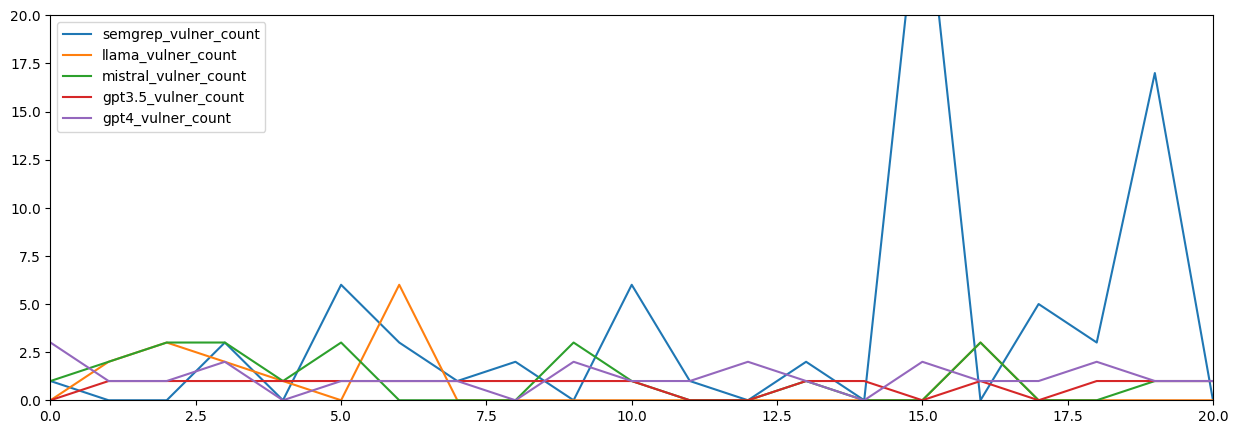

In [88]:
import matplotlib.pyplot as plt
merged_data[['semgrep_vulner_count', 'llama_vulner_count', 'mistral_vulner_count', 'gpt3.5_vulner_count', 'gpt4_vulner_count']].plot(figsize=(15, 5))
plt.ylim([0,20])
plt.xlim([0,20])